In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


## Q1. Explain the Problem

**1) What is your binary outcome variable?**  
The binary outcome variable in this problem is the **type of waste**:  
- `0` for **metal**  
- `1` for **paper**  

**2) What’s the size of the images? Provide five image examples.**  
All images have been resized to **64x64 pixels** and converted to **grayscale** to standardize the input format and reduce computational load.

Below are 5 sample images from each category:


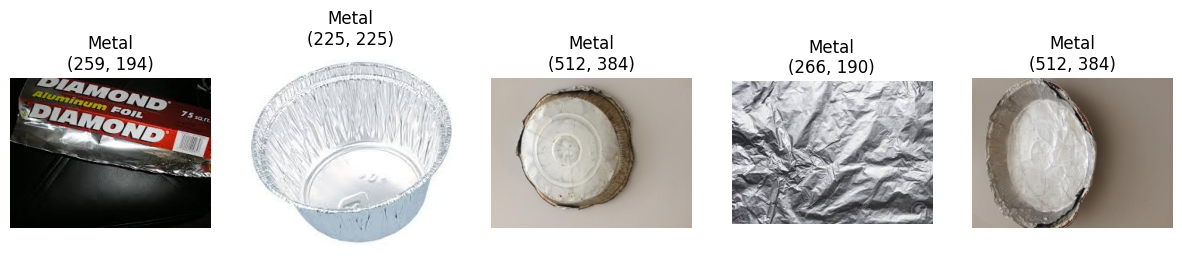

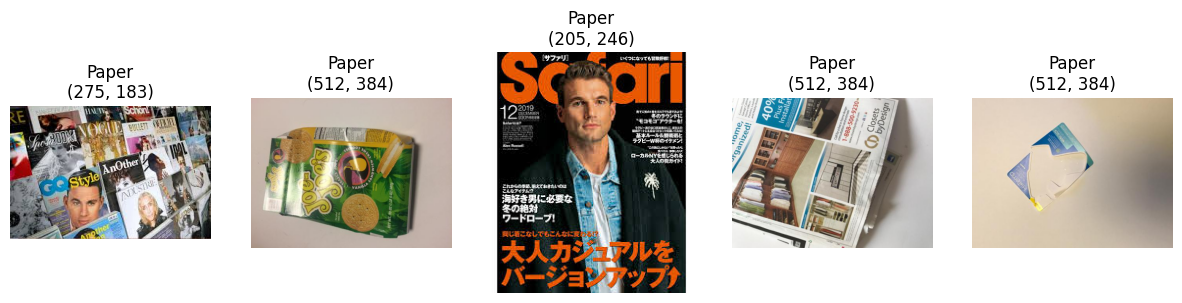

In [70]:
# Display size of each image under its picture
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, metal_file in enumerate(os.listdir("Dataset/metal")[:5]):
    metal_path = os.path.join("Dataset/metal", metal_file)
    try:
        metal_image = Image.open(metal_path)
        axes[i].imshow(metal_image, cmap='gray')
        axes[i].set_title(f"Metal\n{metal_image.size}")
        axes[i].axis('off')
    except Exception as e:
        print(f"Error loading metal image {i+1}: {e}")

plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, paper_file in enumerate(os.listdir("Dataset/paper")[:5]):
    paper_path = os.path.join("Dataset/paper", paper_file)
    try:
        paper_image = Image.open(paper_path)
        axes[i].imshow(paper_image, cmap='gray')
        axes[i].set_title(f"Paper\n{paper_image.size}")
        axes[i].axis('off')
    except Exception as e:
        print(f"Error loading paper image {i+1}: {e}")

plt.show()

In [71]:
def load_images_from_folder(folder_path, label, image_size=(64, 64)):
    X = []
    Y = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = imageio.imread(img_path, pilmode='L')  # Grayscale
            img = np.resize(img, image_size)
            X.append(img.flatten())
            Y.append(label)
        except:
            continue
    return np.array(X), np.array(Y)


In [72]:
# Define folder paths
metal_folder = 'Dataset/metal'
paper_folder = 'Dataset/paper'

# Load data
X_metal, y_metal = load_images_from_folder(metal_folder, label=0)
X_paper, y_paper = load_images_from_folder(paper_folder, label=1)

# Combine and shuffle
X = np.concatenate((X_metal, X_paper), axis=0)
Y = np.concatenate((y_metal, y_paper), axis=0)
X, Y = shuffle(X, Y, random_state=42)


C:\Users\yuhes\AppData\Local\Temp\ipykernel_39388\2026548941.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path, pilmode='L')  # Grayscale


### Q2. Describe the Dataset

**1) How many observations do you have in your dataset?**  
The dataset consists of images from the "metal" and "paper" folders. After loading and filtering valid images:
- **Total Observations:** *1819*

**2) How many observations have an outcome of zero, and how many have an outcome of one?**  
- **Metal (label = 0):** *769*  
- **Paper (label = 1):** *1050*

The dataset has a fairly balanced distribution of the two classes, ensuring effective learning for a binary classification model.


In [73]:
print("Metal directory size:", len(os.listdir(metal_folder)))
print("Paper directory size:", len(os.listdir(paper_folder)))
print("Total Observations loaded:", len(X))

Metal directory size: 769
Paper directory size: 1050
Total Observations loaded: 1819


### Q3. Split the Dataset

We split the dataset into three parts:
- **Training set (~60%)**
- **Cross-validation set (~20%)**
- **Test set (~20%)**

The splitting was done using `train_test_split()` from Scikit-learn with stratification to maintain class balance.


In [74]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))
print("Unique labels in Y:", unique)
print("Counts of each label in Y:", counts)

{np.int64(0): np.int64(769), np.int64(1): np.int64(1050)}
Unique labels in Y: [0 1]
Counts of each label in Y: [ 769 1050]


In [75]:
# Split the data into training, validation, and test sets
X = X / 255.0
X1, X_test, Y1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_cv, Y_train, Y_cv = train_test_split(X1, Y1, test_size=0.25, random_state=42, stratify=Y1)

In [76]:
print("Training set size:", X_train.shape, Y_train.shape)
print("Cross-validation set size:", X_cv.shape, Y_cv.shape)
print("Test set size:", X_test.shape, Y_test.shape)

Training set size: (1091, 4096) (1091,)
Cross-validation set size: (364, 4096) (364,)
Test set size: (364, 4096) (364,)


## Functions

In [77]:
def sigmoid(z):
    # z = np.clip(z, -500, 500)  # Avoid overflow in exp
    return 1 / (1 + np.exp(-z))

def compute_cost(Y, Y_hat):
    m = Y.shape[0]
    cost = -np.mean(Y * np.log(Y_hat + 1e-9) + (1 - Y) * np.log(1 - Y_hat + 1e-9))
    return cost

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

# Reshape Y to column vectors
Y_train = Y_train.reshape(-1, 1)
Y_cv = Y_cv.reshape(-1, 1)

### Q4. Model Implementation and Results

We implemented and trained three models:


#### 1) Logistic Regression (No Hidden Layers)

- **Training Accuracy:** *0.5829514207149404*  
- **Validation Accuracy:** *0.5769230769230769*  
- Cost was plotted every 100 iterations to visualize convergence.  
- This model forms the baseline for binary classification performance.

In [78]:
def logistic_regression(X, Y, X_val, Y_val, alpha=0.001, num_iter=2000):
    m, n = X.shape
    w = np.zeros((n, 1))
    b = 0
    train_costs = []
    val_costs = []

    for i in range(num_iter):
        Z = np.dot(X, w) + b
        A = sigmoid(Z)
        cost = compute_cost(Y, A)
        
        dw = np.dot(X.T, (A - Y)) / m
        db = np.sum(A - Y) / m
        
        w -= alpha * dw
        b -= alpha * db

        if i % 100 == 0:
            A_val = sigmoid(np.dot(X_val, w) + b)
            val_cost = compute_cost(Y_val, A_val)
            train_costs.append(cost)
            val_costs.append(val_cost)
            print(f"Iteration {i} - Train Cost: {cost:.4f}, Val Cost: {val_cost:.4f}")
    
    return w, b, train_costs[1:], val_costs[1:]


Iteration 0 - Train Cost: 0.6931, Val Cost: 0.6891
Iteration 100 - Train Cost: 0.6810, Val Cost: 0.6840
Iteration 200 - Train Cost: 0.6764, Val Cost: 0.6803
Iteration 300 - Train Cost: 0.6727, Val Cost: 0.6775
Iteration 400 - Train Cost: 0.6696, Val Cost: 0.6753
Iteration 500 - Train Cost: 0.6670, Val Cost: 0.6736
Iteration 600 - Train Cost: 0.6647, Val Cost: 0.6722
Iteration 700 - Train Cost: 0.6626, Val Cost: 0.6710
Iteration 800 - Train Cost: 0.6607, Val Cost: 0.6700
Iteration 900 - Train Cost: 0.6589, Val Cost: 0.6692
Iteration 1000 - Train Cost: 0.6572, Val Cost: 0.6685
Iteration 1100 - Train Cost: 0.6557, Val Cost: 0.6678
Iteration 1200 - Train Cost: 0.6542, Val Cost: 0.6673
Iteration 1300 - Train Cost: 0.6528, Val Cost: 0.6668
Iteration 1400 - Train Cost: 0.6514, Val Cost: 0.6663
Iteration 1500 - Train Cost: 0.6501, Val Cost: 0.6659
Iteration 1600 - Train Cost: 0.6488, Val Cost: 0.6655
Iteration 1700 - Train Cost: 0.6475, Val Cost: 0.6652
Iteration 1800 - Train Cost: 0.6463, Val

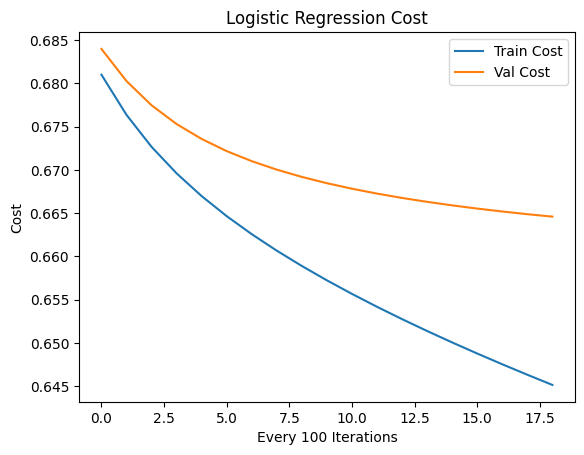

In [79]:
# Load images from the dataset
w_lr, b_lr, train_costs_lr, val_costs_lr = logistic_regression(X_train, Y_train, X_cv, Y_cv)

# Accuracy
def predict_lr(X, w, b):
    A = sigmoid(np.dot(X, w) + b)
    return (A > 0.5).astype(int)

print("Training Accuracy:", np.mean(predict_lr(X_train, w_lr, b_lr) == Y_train))
print("Validation Accuracy:", np.mean(predict_lr(X_cv, w_lr, b_lr) == Y_cv))

# Plot cost
plt.plot(train_costs_lr, label='Train Cost')
plt.plot(val_costs_lr, label='Val Cost')
plt.title("Logistic Regression Cost")
plt.xlabel("Every 100 Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()


#### 2) Neural Network with 1 Hidden Layer (4 Units)

- **Architecture:**  
  - Input layer → 4 Hidden units (ReLU) → Output layer (Sigmoid)

- **Training Accuracy:** *0.5774518790100825*
- **Validation Accuracy:** *0.5741758241758241*
- Cost curves were plotted for both training and validation sets.




In [82]:
def nn_one_hidden(X, Y, X_val, Y_val, alpha=0.001, num_iter=3000):
    m, n = X.shape
    np.random.seed(1)
    W1 = np.random.randn(n, 4) * 0.01
    b1 = np.zeros((1, 4))
    W2 = np.random.randn(4, 1) * 0.01
    b2 = np.zeros((1, 1))

    train_costs = []
    val_costs = []

    for i in range(num_iter):
        Z1 = np.dot(X, W1) + b1
        A1 = relu(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)

        cost = compute_cost(Y, A2)

        dZ2 = A2 - Y
        dW2 = np.dot(A1.T, dZ2) / m
        db2 = np.sum(dZ2) / m

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        W2 -= alpha * dW2
        b2 -= alpha * db2
        W1 -= alpha * dW1
        b1 -= alpha * db1

        if i % 100 == 0:
            A2_val = sigmoid(np.dot(relu(np.dot(X_val, W1) + b1), W2) + b2)
            val_cost = compute_cost(Y_val, A2_val)
            train_costs.append(cost)
            val_costs.append(val_cost)
            print(f"Iteration {i} - Train Cost: {cost:.4f}, Val Cost: {val_cost:.4f}")

    return W1, b1, W2, b2, train_costs, val_costs


Iteration 0 - Train Cost: 0.6927, Val Cost: 0.6927
Iteration 100 - Train Cost: 0.6916, Val Cost: 0.6917
Iteration 200 - Train Cost: 0.6904, Val Cost: 0.6906
Iteration 300 - Train Cost: 0.6892, Val Cost: 0.6896
Iteration 400 - Train Cost: 0.6881, Val Cost: 0.6887
Iteration 500 - Train Cost: 0.6872, Val Cost: 0.6880
Iteration 600 - Train Cost: 0.6866, Val Cost: 0.6875
Iteration 700 - Train Cost: 0.6861, Val Cost: 0.6873
Iteration 800 - Train Cost: 0.6859, Val Cost: 0.6872
Iteration 900 - Train Cost: 0.6857, Val Cost: 0.6871
Iteration 1000 - Train Cost: 0.6856, Val Cost: 0.6871
Iteration 1100 - Train Cost: 0.6855, Val Cost: 0.6870
Iteration 1200 - Train Cost: 0.6855, Val Cost: 0.6870
Iteration 1300 - Train Cost: 0.6854, Val Cost: 0.6869
Iteration 1400 - Train Cost: 0.6853, Val Cost: 0.6868
Iteration 1500 - Train Cost: 0.6852, Val Cost: 0.6867
Iteration 1600 - Train Cost: 0.6852, Val Cost: 0.6867
Iteration 1700 - Train Cost: 0.6851, Val Cost: 0.6866
Iteration 1800 - Train Cost: 0.6850, Val

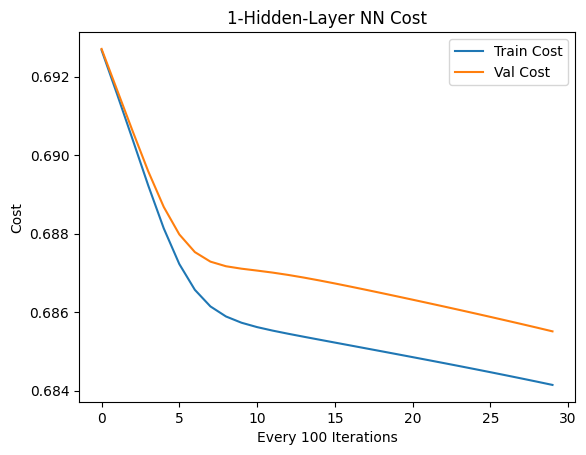

In [83]:
W1, b1, W2, b2, train_costs_nn1, val_costs_nn1 = nn_one_hidden(X_train, Y_train, X_cv, Y_cv)

# Accuracy
def predict_nn1(X):
    A1 = relu(np.dot(X, W1) + b1)
    A2 = sigmoid(np.dot(A1, W2) + b2)
    return (A2 > 0.5).astype(int)

print("Training Accuracy:", np.mean(predict_nn1(X_train) == Y_train))
print("Validation Accuracy:", np.mean(predict_nn1(X_cv) == Y_cv))

plt.plot(train_costs_nn1, label='Train Cost')
plt.plot(val_costs_nn1, label='Val Cost')
plt.title("1-Hidden-Layer NN Cost")
plt.xlabel("Every 100 Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()


#### 3) Neural Network with 2 Hidden Layers (7 and 4 Units)

- **Architecture:**  
  - Input layer → 7 Hidden units (ReLU) → 4 Hidden units (ReLU) → Output layer (Sigmoid)

- **Training Accuracy:** *0.5783684692942255*
- **Validation Accuracy:** *0.5741758241758241*
- This deeper model showed improved performance and generalization capability.

In [84]:
def nn_two_hidden(X, Y, X_val, Y_val, alpha=0.02, num_iter=2000):
    m, n = X.shape
    np.random.seed(1)
    
    # Initialize parameters
    W1 = np.random.randn(n, 7) * 0.01
    b1 = np.zeros((1, 7))
    
    W2 = np.random.randn(7, 4) * 0.01
    b2 = np.zeros((1, 4))
    
    W3 = np.random.randn(4, 1) * 0.01
    b3 = np.zeros((1, 1))
    
    train_costs = []
    val_costs = []

    for i in range(num_iter):
        # Forward Propagation
        Z1 = np.dot(X, W1) + b1
        A1 = relu(Z1)
        
        Z2 = np.dot(A1, W2) + b2
        A2 = relu(Z2)
        
        Z3 = np.dot(A2, W3) + b3
        A3 = sigmoid(Z3)

        # Cost
        cost = compute_cost(Y, A3)

        # Backward Propagation
        dZ3 = A3 - Y
        dW3 = np.dot(A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = np.dot(dZ3, W3.T)
        dZ2 = dA2 * relu_derivative(Z2)
        dW2 = np.dot(A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Parameter updates
        W3 -= alpha * dW3
        b3 -= alpha * db3
        W2 -= alpha * dW2
        b2 -= alpha * db2
        W1 -= alpha * dW1
        b1 -= alpha * db1

        if i % 100 == 0:
            # Validation Cost
            Z1_val = np.dot(X_val, W1) + b1
            A1_val = relu(Z1_val)
            Z2_val = np.dot(A1_val, W2) + b2
            A2_val = relu(Z2_val)
            Z3_val = np.dot(A2_val, W3) + b3
            A3_val = sigmoid(Z3_val)
            val_cost = compute_cost(Y_val, A3_val)

            train_costs.append(cost)
            val_costs.append(val_cost)
            print(f"Iteration {i} - Train Cost: {cost:.4f}, Val Cost: {val_cost:.4f}")
    
    return W1, b1, W2, b2, W3, b3, train_costs, val_costs


In [85]:
def predict_nn2(X, W1, b1, W2, b2, W3, b3):
    A1 = relu(np.dot(X, W1) + b1)
    A2 = relu(np.dot(A1, W2) + b2)
    A3 = sigmoid(np.dot(A2, W3) + b3)
    return (A3 > 0.5).astype(int)


Iteration 0 - Train Cost: 0.6931, Val Cost: 0.6930
Iteration 100 - Train Cost: 0.6855, Val Cost: 0.6856
Iteration 200 - Train Cost: 0.6828, Val Cost: 0.6828
Iteration 300 - Train Cost: 0.6817, Val Cost: 0.6818
Iteration 400 - Train Cost: 0.6813, Val Cost: 0.6815
Iteration 500 - Train Cost: 0.6812, Val Cost: 0.6813
Iteration 600 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 700 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 800 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 900 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1000 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1100 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1200 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1300 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1400 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1500 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1600 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1700 - Train Cost: 0.6811, Val Cost: 0.6813
Iteration 1800 - Train Cost: 0.6811, Val

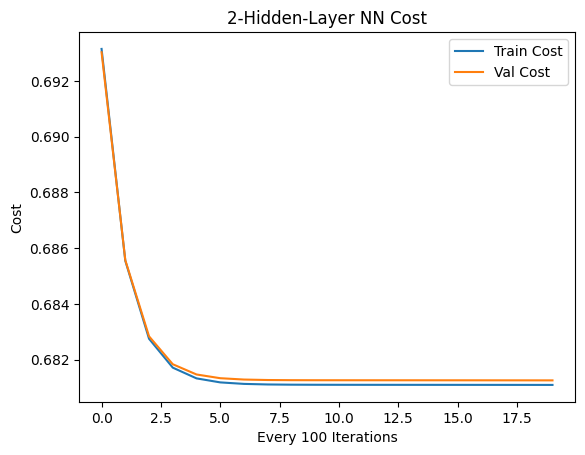

In [86]:
W1_2, b1_2, W2_2, b2_2, W3_2, b3_2, train_costs_2, val_costs_2 = nn_two_hidden(
    X_train, Y_train, X_cv, Y_cv, alpha=0.02, num_iter=2000
)

# Accuracy
print("Training Accuracy:", np.mean(predict_nn2(X_train, W1_2, b1_2, W2_2, b2_2, W3_2, b3_2) == Y_train))
print("Validation Accuracy:", np.mean(predict_nn2(X_cv, W1_2, b1_2, W2_2, b2_2, W3_2, b3_2) == Y_cv))

# Plot Cost
plt.plot(train_costs_2, label='Train Cost')
plt.plot(val_costs_2, label='Val Cost')
plt.title("2-Hidden-Layer NN Cost")
plt.xlabel("Every 100 Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()
